In [2]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from matplotlib.image import imread
import matplotlib.pyplot as plt
import pandas as pd
import time, cv2
import numpy as np
from sklearn import manifold, decomposition
import seaborn as sns
from sklearn import cluster, metrics
import zipfile as zf

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from plot_keras_history import show_history, plot_history

from sklearn.model_selection import GridSearchCV
import scikeras
from scikeras.wrappers import KerasClassifier
import os
import shutil


# Resnet50 classification

In [3]:
def create_model_fct_resnet50() :
    # Récupération modèle pré-entraîné
    model0 = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [4]:
files = zf.ZipFile("Images.zip", 'r')
files.extractall("./Images_all/")
files.close()

path = "./Images_all/Images/"

raw = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

raw['label'] = raw['product_category_tree'].apply(lambda x: x.split('>>')[0].split('"')[1])
raw = raw[['image','label']]

images = os.listdir(path)
images_train, images_test = train_test_split(images, test_size=0.2, random_state=42)

path_train = "./dataset_train/"
path_test = "./dataset_test/"

shutil.rmtree(path_train)
shutil.rmtree(path_test)

for image in images_train:
    label = raw[raw.image==image].label.item().replace(" ","").replace("&","")
    if not os.path.exists(path_train+label):
        os.makedirs(path_train+label)
    shutil.copy(os.path.join(path, image), os.path.join(path_train+label, image))

for image in images_test:
    label = raw[raw.image==image].label.item().replace(" ","").replace("&","")
    if not os.path.exists(path_test+label):
        os.makedirs(path_test+label)
    shutil.copy(os.path.join(path, image), os.path.join(path_test+label, image))


# Méthode par dataset

In [4]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None, shuffle=True) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical', shuffle = shuffle,
                    class_names=None, batch_size=32, image_size=(224, 224), seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [5]:
dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training', shuffle=True)
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation', shuffle=True)
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None, shuffle=False)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [6]:
dataset_grid = dataset_fct(path_train, validation_split=0, data_type=None, shuffle=True)


Found 840 files belonging to 7 classes.


## Méthode par dataset : sans augmentation / sans grid search

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

20/20 [==============================] - 68s 3s/step - loss: 0.4207 - accuracy: 0.8603 - val_loss: 0.8331 - val_accuracy: 0.7476
Epoch 6/10
20/20 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.9079
Epoch 6: val_loss improved from 0.83313 to 0.80438, saving model to .\model1_best_weights.h5
20/20 [==============================] - 72s 4s/step - loss: 0.2648 - accuracy: 0.9079 - val_loss: 0.8044 - val_accuracy: 0.7619
Epoch 7/10
20/20 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.9095
Epoch 7: val_loss did not improve from 0.80438
20/20 [==============================] - 69s 3s/step - loss: 0.2903 - accuracy: 0.9095 - val_loss: 1.0116 - val_accuracy: 0.7476
Epoch 8/10
20/20 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9302
Epoch 8: val_loss did not improve from 0.80438
20/20 [==============================] - 62s 3s/step - loss: 0.2152 - accuracy: 0.9302 - val_loss: 0.9474 - val_accuracy: 0.7571
Epoch 9/10
20/2

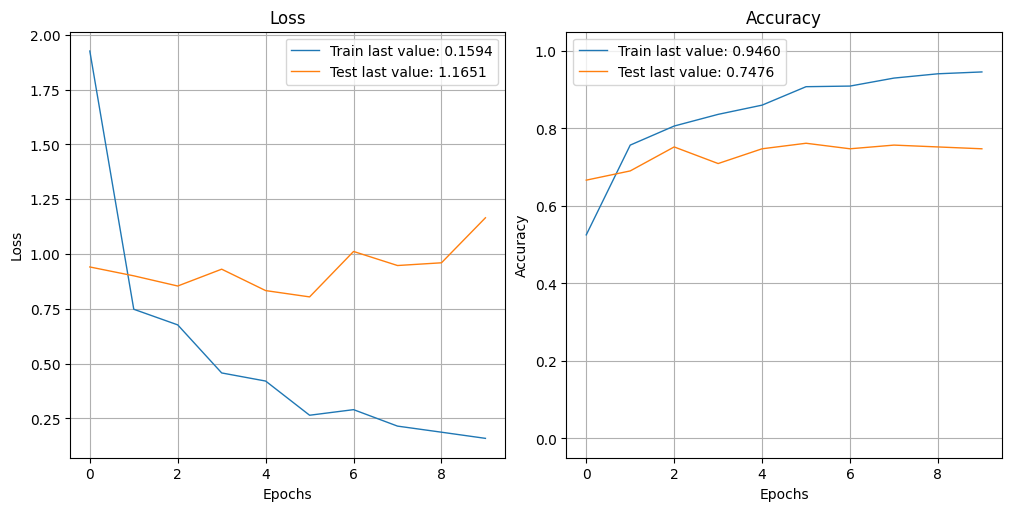

7/7 [==============================] - 18s 2s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]

[0 0 5 0 0 3 0 0 0 4 0 3 4 2 3 0 0 0 0 0 4 0 0 0 4 0 0 0 4 0 0 0 4 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 4 1 1 4 1 0 2 2 2 2 2 2 2 5 2 2 2
 1 6 2 2 2 2 2 2 0 2 2 2 2 2 5 3 2 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3
 3 4 4 4 4 3 4 4 0 3 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4 0 4 4 0 4 5 5 5 5 5 5
 5 1 5 5 5 5 5 5 5 5 5 5 5 5 4 1 5 5 2 5 5 0 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[22  0  1  3  6  1  0]
 [ 1 26  0  1  2  0  0]
 [ 1  1 21  0  0  1  1]
 [ 1  1  1 20  0  1  0

<Axes: >

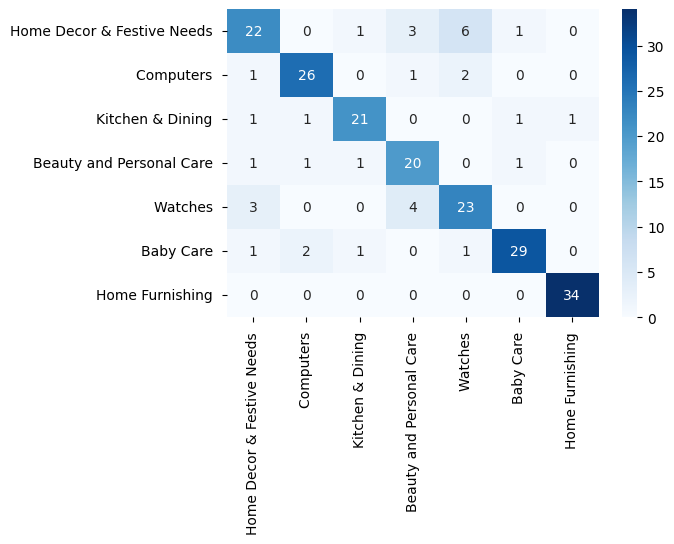

In [7]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct_resnet50()

# Création du callback
model1_save_path = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

with tf.device('/gpu:0'): 
    history1 = model1.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=10, callbacks=callbacks_list, verbose=1)
    
loss, accuracy = model1.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

model1.load_weights(model1_save_path)

loss, accuracy = model1.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

labels_dataset = dataset_test.map(lambda _, labels: labels)
cat = np.concatenate(list(labels_dataset.as_numpy_iterator()))
y_test_num = np.argmax(cat, axis=1)

y_test_pred = np.argmax(model1.predict(dataset_test), axis=1)
print(y_test_num)
print()
print(y_test_pred)

conf_mat = metrics.confusion_matrix(y_test_num,y_test_pred)

print(conf_mat)
print()
print(metrics.classification_report(y_test_num, y_test_pred))

df_cm = pd.DataFrame(conf_mat, index = [label for label in set(raw["label"])],
              columns = [label for label in set(raw["label"])])
plt.figure(figsize = (6,4))

sns.heatmap(df_cm, annot=True, cmap="Blues")

## Méthode par dataset : sans augmentation / avec grid search

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 conv1_relu (Activation)        (None, 112, 112, 64  0           ['conv1_bn[0][0]']               
                                )                                                                 
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_relu[0][0]']             
                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_blo

 conv2_block3_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       
                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_blo

 conv3_block3_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_add (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block2_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block5_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block1_1_relu[0][0]']    
                                                                                                  
 conv2_block1_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block4_1_relu[0][0]']    
                                                                                                  
 conv3_block4_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_1_bn[0][0]']      
 n)       

                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization) 

 conv2_block1_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, 56, 56, 256)  16640       ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block4_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block4_2_relu[0][0]']    
                                                                                                  
 conv3_block4_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block4_3_conv[0][0]']    
 ization)                                                                                         
          

 conv4_block3_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block3_1_relu[0][0]']    
                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block6_1_relu[0][0]']    
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_2_bn[0][0]']      
 n)       

 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv2_block1_0_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_0_bn[0][0]',      
                                                                  'conv2_block1_3_bn[0][0]']      
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_0_bn[0][0]',      
                                                                  'conv3_block1_3_bn[0][0]']      
                                                                                                  
 conv3_blo

 ization)                                                                                         
                                                                                                  
 conv3_block4_add (Add)         (None, 28, 28, 512)  0           ['conv3_block3_out[0][0]',       
                                                                  'conv3_block4_3_bn[0][0]']      
                                                                                                  
 conv3_block4_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block4_add[0][0]']       
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131328      ['conv3_block4_out[0][0]']       
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block3_add (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_bn[0][0]']      
          

 conv4_block6_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block6_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block6_add (Add)         (None, 14, 14, 1024  0           ['conv4_block5_out[0][0]',       
          

 ization)                                                                                         
                                                                                                  
 conv5_block3_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block3_2_relu[0][0]']    
                                                                                                  
 conv5_block3_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

                                                                                                  
 conv2_block1_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block1_add[0][0]']       
                                                                                                  
 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block1_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block1_add[0][0]']       
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
          

                                )                                 'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block6_add (Add)         (None, 14, 14, 1024  0           ['conv4_block5_out[0][0]',       
                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block3_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_6 (Gl  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_12 (Dense)               (None, 256)          524544      ['global_average_pooling2d_6[0][0
          

 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
          

                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_7 (Gl  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_14 (Dense)               (None, 256)          524544      ['global_average_pooling2d_7[0][0
                                                                 ]']                              
                                                                                                  
 dropout_7 (Dropout)            (None, 256)          0           ['dense_14[0][0]']               
          

 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
          

                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization) 

 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_blo

 global_average_pooling2d_8 (Gl  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_16 (Dense)               (None, 256)          524544      ['global_average_pooling2d_8[0][0
                                                                 ]']                              
                                                                                                  
 dropout_8 (Dropout)            (None, 256)          0           ['dense_16[0][0]']               
                                                                                                  
 dense_17 (Dense)               (None, 7)            1799        ['dropout_8[0][0]']              
                                                                                                  
Total para

 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
          

                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 dense_18 (Dense)               (None, 256)          524544      ['global_average_pooling2d_9[0][0
                                                                 ]']                              
                                                                                                  
 dropout_9 (Dropout)            (None, 256)          0           ['dense_18[0][0]']               
                                                                                                  
 dense_19 (Dense)               (None, 7)            1799        ['dropout_9[0][0]']              
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/10
40/40 [==============================] - 37s 866ms/step - loss: 2.9060 - accuracy: 0.1571
Epoch 2/10
40/40 [

                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
          

                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 dropout_10 (Dropout)           (None, 256)          0           ['dense_20[0][0]']               
                                                                                                  
 dense_21 (Dense)               (None, 7)            1799        ['dropout_10[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/15
40/40 [==============================] - 41s 950ms/step - loss: 2.9071 - accuracy: 0.1413
Epoch 2/15
40/40 [==============================] - 38s 956ms/step - loss: 1.9971 - accuracy: 0.2032
Epoch 3/15
40/40 [==============================] - 39s 978ms/step - loss: 1.9522 - accuracy: 0.2540
Epoch 4/15
40/40 [==============================] - 40s 995ms/step - loss: 1.8646 - accuracy: 0.2762
Epoch 5/15
4

                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
          

                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
          

                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)       

                                                                 0]']                             
                                                                                                  
 dropout_11 (Dropout)           (None, 256)          0           ['dense_22[0][0]']               
                                                                                                  
 dense_23 (Dense)               (None, 7)            1799        ['dropout_11[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/15
40/40 [==============================] - 37s 874ms/step - loss: 3.0834 - accuracy: 0.1270
Epoch 2/15
40/40 [==============================] - 35s 875ms/step - loss: 2.0250 - accuracy: 0.2111
Epoch 3/15
40/40

 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
          

 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
          

 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 dense_24 (Dense)               (None, 256)          524544      ['global_average_pooling2d_12[0][
                                                                 0]']                             
                                                                                                  
 dropout_12 (Dropout)           (None, 256)          0           ['dense_24[0][0]']               
                                                                                                  
 dense_25 (Dense)               (None, 7)            1799        ['dropout_12[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/15
40/40 [==

 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
          

                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization) 

 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_blo

 global_average_pooling2d_13 (G  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_26 (Dense)               (None, 256)          524544      ['global_average_pooling2d_13[0][
                                                                 0]']                             
                                                                                                  
 dropout_13 (Dropout)           (None, 256)          0           ['dense_26[0][0]']               
                                                                                                  
 dense_27 (Dense)               (None, 7)            1799        ['dropout_13[0][0]']             
                                                                                                  
Total para

                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_14 (G  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_28 (Dense)               (None, 256)          524544      ['global_average_pooling2d_14[0][
                                                                 0]']                             
                                                                                                  
 dropout_14 (Dropout)           (None, 256)          0           ['dense_28[0][0]']               
                                                                                                  
 dense_29 

 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_blo

 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
          

                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
          

                                                                                                  
 dense_31 (Dense)               (None, 7)            1799        ['dropout_15[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/5
20/20 [==============================] - 36s 2s/step - loss: 3.2485 - accuracy: 0.1238
Epoch 2/5
20/20 [==============================] - 34s 2s/step - loss: 1.9305 - accuracy: 0.2413
Epoch 3/5
20/20 [==============================] - 34s 2s/step - loss: 1.8598 - accuracy: 0.2619
Epoch 4/5
20/20 [==============================] - 34s 2s/step - loss: 1.6989 - accuracy: 0.3556
Epoch 5/5
7/7 [==============================] - 13s 2s/step
Model: "model_16"
________________________________________________

 ization)                                                                                         
                                                                                                  
 conv2_block2_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       
                                                                  'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block2_add[0][0]']       
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block2_out[0][0]']       
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization) 

 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_block3_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block2_out[0][0]']       
                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_block1_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_blo

                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 14, 14, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
                                                                                                  
 conv4_block4_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block4_add[0][0]']       
                                )                                                                 
          

 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block1_2_relu[0][0]']    
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization) 

                                )                                                                 
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block4_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block4_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
          

 ization)                                                                                         
                                                                                                  
 conv5_block1_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization) 

 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_19[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1_conv[0][0]']             
                                )                                                                 
                                                                                                  
 conv1_relu (Activation)        (None, 112, 112, 64  0           ['conv1_bn[0][0]']               
                                )                                                                 
          

 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block3_3_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block2_2_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1_conv[0][0]']             
                                )                                                                 
                                                                                                  
 conv1_relu (Activation)        (None, 112, 112, 64  0           ['conv1_bn[0][0]']               
                                )                                                                 
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_relu[0][0]']             
                                )                                                                 
                                                                                                  
 pool1_poo

 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       
                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_blo

 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_add (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_blo

 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block2_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
          

 conv4_block5_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block5_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv1_relu (Activation)        (None, 112, 112, 64  0           ['conv1_bn[0][0]']               
                                )                                                                 
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_relu[0][0]']             
                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_blo

 conv2_block3_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       
                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_blo

 conv3_block3_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_add (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block2_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block5_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
          

                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)       

                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)       

                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)       

 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
          

                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block1_1_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block4_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
          

 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_blo

                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block1_1_relu[0][0]']    
          

                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block1_1_relu[0][0]']    
          

                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block4_1_relu[0][0]']    
          

 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
          

 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_blo

 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_blo

                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
          

 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_blo

 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
          

                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)       

                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)       

                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)       

 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
          

                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block1_1_relu[0][0]']    
                                                                                                  
 conv2_block1_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_2_bn[0][0]']      
 n)                                                                                               
          

 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      
 n)                                                                                               
          

 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block4_1_relu[0][0]']    
                                                                                                  
 conv3_block4_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_2_bn[0][0]']      
 n)                                                                                               
          

 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block3_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block6_1_relu[0][0]']    
          

                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
          

 n)                                                                                               
                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, 56, 56, 256)  16640       ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    
                                                                                                  
 conv2_block1_0_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block4_2_relu[0][0]']    
                                                                                                  
 conv3_block4_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block4_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_add (Add)         (None, 28, 28, 512)  0           ['conv3_block3_out[0][0]',       
                                                                  'conv3_block4_3_bn[0][0]']      
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block6_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block6_1_relu[0][0]']    
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block6_2_relu[0][0]']    
                                )                                                                 
          

 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv2_block1_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_0_bn[0][0]',      
                                                                  'conv2_block1_3_bn[0][0]']      
                                                                                                  
 conv2_block1_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block1_add[0][0]']       
                                                                                                  
 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
                                                                                                  
 conv2_blo

 conv3_block1_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_0_bn[0][0]',      
                                                                  'conv3_block1_3_bn[0][0]']      
                                                                                                  
 conv3_block1_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block1_add[0][0]']       
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block4_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block4_add[0][0]']       
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131328      ['conv3_block4_out[0][0]']       
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block3_add (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_blo

                                )                                                                 
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block6_add (Add)         (None, 14, 14, 1024  0           ['conv4_block5_out[0][0]',       
                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
          

                                                                                                  
 conv5_block3_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block3_2_relu[0][0]']    
                                                                                                  
 conv5_block3_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
          

                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_30 (G  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_60 (Dense)               (None, 256)          524544      ['global_average_pooling2d_30[0][
                                                                 0]']                             
                                                                                                  
 dropout_30 (Dropout)           (None, 256)          0           ['dense_60[0][0]']               
                                                                                                  
 dense_61 

 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
          

 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
          

 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 dense_62 (Dense)               (None, 256)          524544      ['global_average_pooling2d_31[0][
                                                                 0]']                             
                                                                                                  
 dropout_31 (Dropout)           (None, 256)          0           ['dense_62[0][0]']               
                                                                                                  
 dense_63 (Dense)               (None, 7)            1799        ['dropout_31[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/10
10/10 [==

                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
          

                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 dropout_32 (Dropout)           (None, 256)          0           ['dense_64[0][0]']               
                                                                                                  
 dense_65 (Dense)               (None, 7)            1799        ['dropout_32[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/10
10/10 [==============================] - 52s 5s/step - loss: 4.0374 - accuracy: 0.1111
Epoch 2/10
10/10 [==============================] - 49s 5s/step - loss: 1.9332 - accuracy: 0.2254
Epoch 3/10
10/10 [==============================] - 49s 5s/step - loss: 1.8049 - accuracy: 0.3270
Epoch 4/10
10/10 [==============================] - 49s 5s/step - loss: 1.7219 - accuracy: 0.3349
Epoch 5/10
10/10 [======

 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       
                                                                  'conv2_block2_3_bn[0][0]']      
          

 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
          

                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
          

 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block1_2_relu[0][0]']    
                                                                                                  
 conv5_blo

Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/10
10/10 [==============================] - 53s 5s/step - loss: 3.7316 - accuracy: 0.1524
Epoch 2/10
10/10 [==============================] - 51s 5s/step - loss: 1.9131 - accuracy: 0.2206
Epoch 3/10
10/10 [==============================] - 51s 5s/step - loss: 1.7981 - accuracy: 0.2873
Epoch 4/10
10/10 [==============================] - 51s 5s/step - loss: 1.7199 - accuracy: 0.3222
Epoch 5/10
10/10 [==============================] - 51s 5s/step - loss: 1.6543 - accuracy: 0.3762
Epoch 6/10
10/10 [==============================] - 50s 5s/step - loss: 1.4741 - accuracy: 0.4381
Epoch 7/10
10/10 [==============================] - 52s 5s/step - loss: 1.4949 - accuracy: 0.4540
Epoch 8/10
10/10 [==============================] - 51s 5s/step - loss: 1.2818 - accuracy: 0.5365
Epoch 9/10
10/10 [==========

                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       
                                                                  'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block2_add[0][0]']       
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block2_out[0][0]']       
          

                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_block3_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block2_out[0][0]']       
          

 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_block1_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block1_add[0][0]']       
          

                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 14, 14, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block1_2_relu[0][0]']    
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block1_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       
                                                                  'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block2_add[0][0]']       
          

                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block2_add[0][0]']       
          

                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
          

 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 14, 14, 1024  0           ['conv4_block3_out[0][0]',       
          

                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block1_2_relu[0][0]']    
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block1_0_conv[0][0]']    
 ization)                                                                                         
          

__________________________________________________________________________________________________
None
Epoch 1/15
10/10 [==============================] - 54s 5s/step - loss: 3.4846 - accuracy: 0.1254
Epoch 2/15
10/10 [==============================] - 50s 5s/step - loss: 1.9203 - accuracy: 0.2032
Epoch 3/15
10/10 [==============================] - 50s 5s/step - loss: 1.8167 - accuracy: 0.2730
Epoch 4/15
10/10 [==============================] - 50s 5s/step - loss: 1.7440 - accuracy: 0.3349
Epoch 5/15
10/10 [==============================] - 49s 5s/step - loss: 1.6026 - accuracy: 0.3937
Epoch 6/15
10/10 [==============================] - 50s 5s/step - loss: 1.5461 - accuracy: 0.3952
Epoch 7/15
10/10 [==============================] - 49s 5s/step - loss: 1.3173 - accuracy: 0.5254
Epoch 8/15
10/10 [==============================] - 50s 5s/step - loss: 1.2661 - accuracy: 0.5349
Epoch 9/15
10/10 [==============================] - 50s 5s/step - loss: 1.1745 - accuracy: 0.5746
Epoch 10/15
10

 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       
                                                                  'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_blo

 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_blo

 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_0_bn[0][0]',      
          

                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block1_2_relu[0][0]']    
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block1_0_conv[0][0]']    
 ization) 

Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/15
10/10 [==============================] - 53s 5s/step - loss: 3.9227 - accuracy: 0.1238
Epoch 2/15
10/10 [==============================] - 50s 5s/step - loss: 1.9082 - accuracy: 0.2190
Epoch 3/15
10/10 [==============================] - 50s 5s/step - loss: 1.8226 - accuracy: 0.2746
Epoch 4/15
10/10 [==============================] - 49s 5s/step - loss: 1.7808 - accuracy: 0.3032
Epoch 5/15
10/10 [==============================] - 49s 5s/step - loss: 1.6273 - accuracy: 0.4063
Epoch 6/15
10/10 [==============================] - 50s 5s/step - loss: 1.5361 - accuracy: 0.4333
Epoch 7/15
10/10 [==============================] - 50s 5s/step - loss: 1.4006 - accuracy: 0.4984
Epoch 8/15
10/10 [==============================] - 49s 5s/step - loss: 1.3261 - accuracy: 0.5286
Epoch 9/15
10/10 [==========

 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       
                                                                  'conv2_block2_3_bn[0][0]']      
          

 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
          

                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
          

 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block1_2_relu[0][0]']    
                                                                                                  
 conv5_blo

Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/15
10/10 [==============================] - 49s 5s/step - loss: 3.6235 - accuracy: 0.1397
Epoch 2/15
10/10 [==============================] - 47s 5s/step - loss: 1.9814 - accuracy: 0.2143
Epoch 3/15
10/10 [==============================] - 46s 5s/step - loss: 1.7911 - accuracy: 0.3032
Epoch 4/15
10/10 [==============================] - 46s 5s/step - loss: 1.7230 - accuracy: 0.3286
Epoch 5/15
10/10 [==============================] - 47s 5s/step - loss: 1.6237 - accuracy: 0.3984
Epoch 6/15
10/10 [==============================] - 47s 5s/step - loss: 1.4685 - accuracy: 0.4524
Epoch 7/15
10/10 [==============================] - 46s 5s/step - loss: 1.4276 - accuracy: 0.4571
Epoch 8/15
10/10 [==============================] - 46s 5s/step - loss: 1.2538 - accuracy: 0.5556
Epoch 9/15
10/10 [==========

                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       
          

                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_out[0][0]',       
          

                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
          

 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block1_2_relu[0][0]']    
          

                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/5
53/53 [==============================] - 76s 1s/step - loss: 2.9147 - accuracy: 0.1345
Epoch 2/5
53/53 [==============================] - 73s 1s/step - loss: 2.0353 - accuracy: 0.1690
Epoch 3/5
53/53 [==============================] - 74s 1s/step - loss: 1.9573 - accuracy: 0.2167
Epoch 4/5
53/53 [==============================] - 74s 1s/step - loss: 1.8808 - accuracy: 0.2679
Epoch 5/5
53/53 [==============================] - 74s 1s/step - loss: 1.8105 - accuracy: 0.2940
Best: 0.163095 using {'batch_size': 16, 'epochs': 5}
Epoch 1/5
20/20 [==============================] - ETA: 0s - loss: 1.9916 - accuracy: 0.5540
Epoch 1: val_loss improved from inf to 1.00748, saving model to .\model2_best_weig

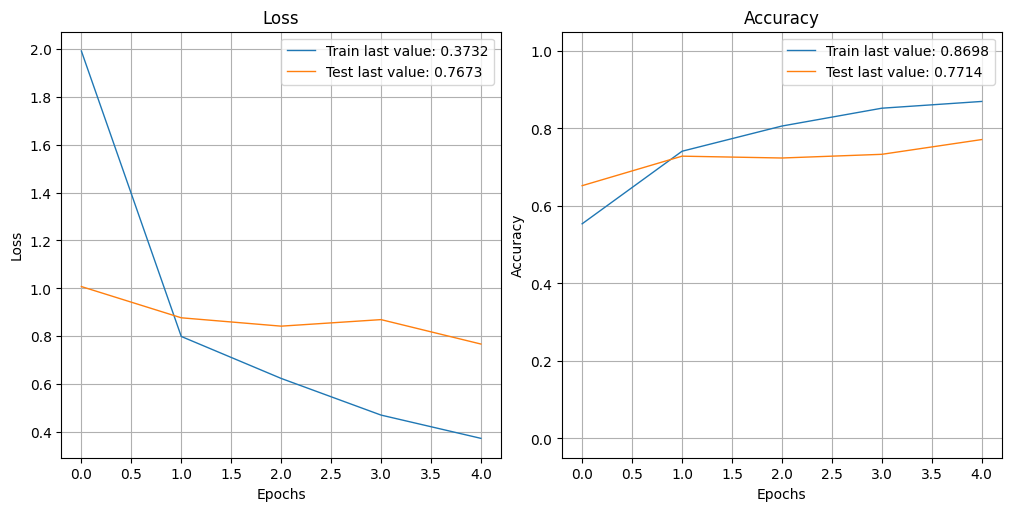

7/7 [==============================] - 19s 3s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]

[0 0 5 4 0 3 4 0 0 4 0 3 4 2 3 0 3 3 0 0 4 0 0 0 4 0 2 0 4 0 0 5 4 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 1 1 2 2 2 2 2 2 1 5 2 2 2
 1 6 2 2 2 2 5 2 5 3 2 2 2 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 4 4 4 3 4 4 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4 4 4 4 4 4 5 5 5 5 5 5
 5 1 5 5 5 5 5 5 5 5 5 5 5 5 4 1 5 5 3 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 6 6 6 6 6 6 6 6 6 6]
[[16  0  2  5  8  2  0]
 [ 0 28  0  2  0  0  0]
 [ 0  2 17  1  0  4  1]
 [ 0  0  0 23  0  1  0

<Axes: >

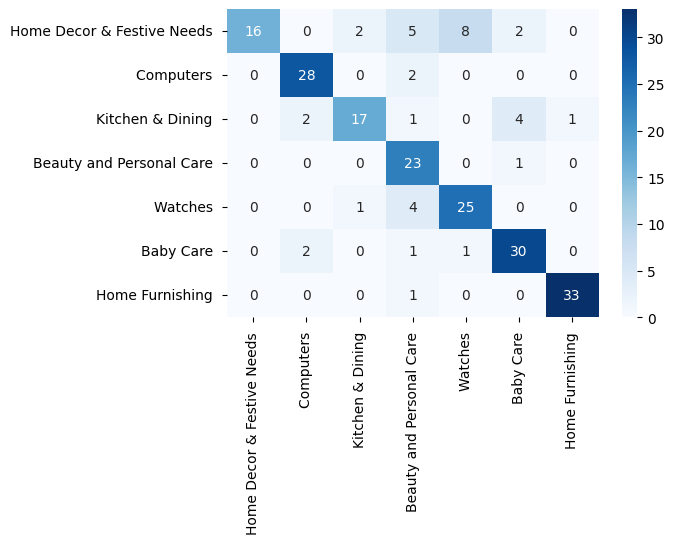

In [8]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct_resnet50()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

model_reset_50 = KerasClassifier(model = create_model_fct_resnet50, verbose = 1)

param_dict = {
    "batch_size" : [16,32,64],
    "epochs" : [5,10,15],
             }

grid = GridSearchCV(
    param_grid = param_dict,
    estimator = model_reset_50,
    scoring = "accuracy",
    cv = 4,
    verbose = 1
)

train_ds = dataset_grid.unbatch()
images_train = list(train_ds.map(lambda x, y: x))
labels_train = list(train_ds.map(lambda x, y: y))

with tf.device('/gpu:0'): 
    grid_model = grid.fit(images_train, labels_train, verbose=1)
    
print("Best: %f using %s" % (grid_model.best_score_, grid_model.best_params_))

with tf.device('/gpu:0'): 
    history2 = model2.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=grid_model.best_params_['batch_size'], epochs=grid_model.best_params_['epochs'], 
                          callbacks=callbacks_list, verbose=1)
    
loss, accuracy = model2.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

labels_dataset = dataset_test.map(lambda _, labels: labels)
cat = np.concatenate(list(labels_dataset.as_numpy_iterator()))
y_test_num = np.argmax(cat, axis=1)

y_test_pred = np.argmax(model2.predict(dataset_test), axis=1)
print(y_test_num)
print()
print(y_test_pred)

conf_mat = metrics.confusion_matrix(y_test_num,y_test_pred)

print(conf_mat)
print()
print(metrics.classification_report(y_test_num, y_test_pred))

df_cm = pd.DataFrame(conf_mat, index = [label for label in set(raw["label"])],
              columns = [label for label in set(raw["label"])])
plt.figure(figsize = (6,4))

sns.heatmap(df_cm, annot=True, cmap="Blues")

# data augmentation méthode par dataframe

In [5]:
raw = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")


labels = raw['product_category_tree'].apply(lambda x: x.split('>>')[0].split('"')[1])
raw['label'] = labels
raw = raw[['image','label']]

path = "./Images_all/Images/"
raw["image"] = path + raw["image"]

In [6]:
# Pour mélanger les images, classées initalement par classe
data = raw.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None, shuffle = True) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image', y_col='label',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=shuffle, seed=42,
                                subset=data_type
                                )
    return data_flow

In [8]:
train, test = np.split(data, [int(0.8 * len(data))])

datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(train, datagen_train, data_type='training', shuffle = True)
val_flow = data_flow_fct(train, datagen_train, data_type='validation', shuffle = True)

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function = preprocess_input)

test_flow = data_flow_fct(test, datagen_test, data_type=None, shuffle = False)

datagen_grid = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0,
    preprocessing_function=preprocess_input)

grid_flow = data_flow_fct(train, datagen_grid, data_type='training', shuffle = True)



Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 840 validated image filenames belonging to 7 classes.


# sans grid

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_40[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

C:\Users\linae\anaconda3\envs\test_env\Lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.70637, saving model to .\model3_best_weights.h5
20/20 [==============================] - 70s 3s/step - loss: 1.9854 - accuracy: 0.5222 - val_loss: 0.7064 - val_accuracy: 0.7905
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.7196 - accuracy: 0.7635
Epoch 2: val_loss improved from 0.70637 to 0.54625, saving model to .\model3_best_weights.h5
20/20 [==============================] - 62s 3s/step - loss: 0.7196 - accuracy: 0.7635 - val_loss: 0.5463 - val_accuracy: 0.8333
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.8016
Epoch 3: val_loss did not improve from 0.54625
20/20 [==============================] - 62s 3s/step - loss: 0.6531 - accuracy: 0.8016 - val_loss: 0.6306 - val_accuracy: 0.8048
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.8206
Epoch 4: val_loss did not improve from 0.54625
20/20 [==============================] - 62s 3s/step -

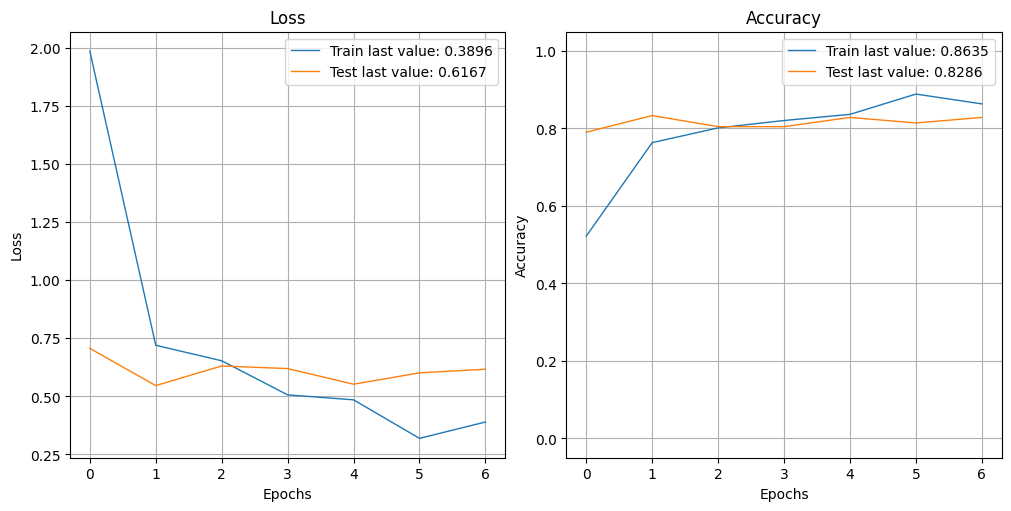

7/7 [==============================] - 18s 2s/step
[1, 0, 0, 1, 1, 3, 4, 4, 5, 1, 6, 2, 0, 1, 4, 3, 0, 4, 2, 0, 3, 6, 0, 6, 6, 3, 5, 4, 3, 5, 6, 4, 6, 5, 0, 0, 3, 6, 2, 2, 3, 6, 5, 5, 4, 6, 1, 0, 6, 2, 3, 3, 1, 1, 4, 2, 5, 0, 3, 4, 1, 0, 4, 0, 3, 6, 3, 1, 1, 1, 1, 3, 6, 1, 6, 2, 6, 1, 2, 3, 5, 6, 1, 3, 2, 0, 1, 0, 1, 4, 2, 0, 6, 5, 1, 5, 0, 3, 0, 6, 2, 1, 5, 4, 6, 5, 0, 2, 2, 5, 6, 5, 3, 1, 5, 4, 1, 1, 0, 4, 5, 4, 5, 0, 5, 5, 3, 3, 2, 3, 2, 3, 5, 6, 3, 1, 3, 4, 4, 0, 4, 6, 1, 0, 5, 0, 6, 4, 3, 3, 4, 4, 0, 2, 2, 5, 4, 1, 3, 2, 4, 6, 2, 0, 5, 6, 1, 3, 1, 5, 5, 2, 6, 0, 4, 2, 0, 2, 2, 5, 6, 4, 6, 2, 1, 3, 5, 0, 4, 6, 5, 2, 1, 5, 6, 1, 6, 3, 1, 1, 2, 6, 5, 4, 2, 2, 0, 0, 0, 2]

[3 0 0 1 1 3 4 4 5 1 6 3 4 1 4 3 0 4 2 0 2 6 4 6 6 4 5 4 3 5 6 4 6 5 0 4 3
 6 3 2 3 6 5 5 4 6 1 0 6 2 3 5 1 1 0 2 5 0 3 4 1 0 4 0 3 6 3 4 1 4 1 3 6 1
 6 5 6 1 2 3 5 6 5 3 2 0 1 0 1 4 2 0 6 5 1 5 0 5 5 6 2 5 5 4 6 5 0 2 5 5 6
 5 5 6 5 4 1 1 0 4 5 4 5 0 5 5 3 0 5 3 1 3 5 6 5 1 3 0 4 0 4 6 1 4 5 3 6 4
 3 3 4 4 0 2 2 5 

<Axes: >

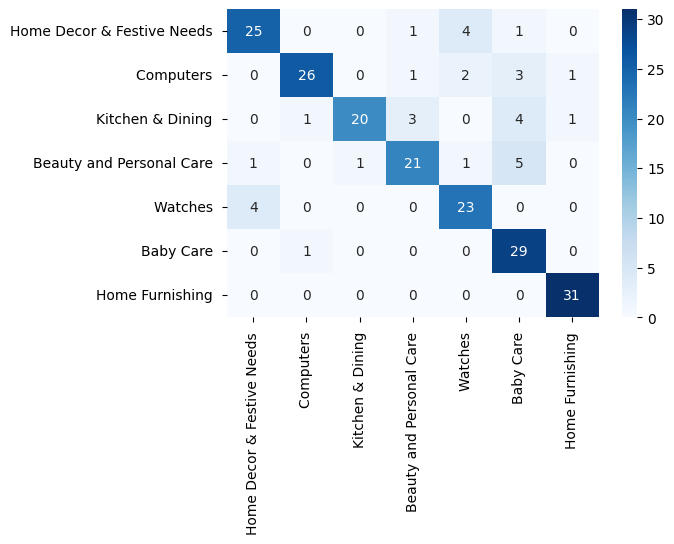

In [14]:
with tf.device('/gpu:0'): 
    model3 = create_model_fct_resnet50()

model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

with tf.device('/gpu:0'): 
    history3 = model3.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=32, epochs=10, callbacks = callbacks_list, verbose=1)
    
loss, accuracy = model3.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

y_test_num = test_flow.labels

y_test_pred = np.argmax(model3.predict(test_flow), axis=1)
print(y_test_num)
print()
print(y_test_pred)

conf_mat = metrics.confusion_matrix(y_test_num,y_test_pred)

print(conf_mat)
print()
print(metrics.classification_report(y_test_num, y_test_pred))

df_cm = pd.DataFrame(conf_mat, index = [label for label in set(raw["label"])],
              columns = [label for label in set(raw["label"])])
plt.figure(figsize = (6,4))

sns.heatmap(df_cm, annot=True, cmap="Blues")


# avec grid search

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_41[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 conv1_relu (Activation)        (None, 112, 112, 64  0           ['conv1_bn[0][0]']               
                                )                                                                 
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_relu[0][0]']             
                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_blo

 conv2_block3_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       
                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_blo

 conv3_block3_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_add (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block2_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block5_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block1_1_relu[0][0]']    
                                                                                                  
 conv2_block1_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block4_1_relu[0][0]']    
                                                                                                  
 conv3_block4_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_1_bn[0][0]']      
 n)       

                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization) 

 conv2_block1_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, 56, 56, 256)  16640       ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block4_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block4_2_relu[0][0]']    
                                                                                                  
 conv3_block4_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block4_3_conv[0][0]']    
 ization)                                                                                         
          

 conv4_block3_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block3_1_relu[0][0]']    
                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block6_1_relu[0][0]']    
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_2_bn[0][0]']      
 n)       

 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv2_block1_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, 56, 56, 256)  16640       ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    
                                                                                                  
 conv2_block1_0_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_0_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_0_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv3_block4_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block4_2_relu[0][0]']    
                                                                                                  
 conv3_block4_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block4_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_add (Add)         (None, 28, 28, 512)  0           ['conv3_block3_out[0][0]',       
          

                                                                                                  
 conv4_block3_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block3_1_relu[0][0]']    
                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block6_1_relu[0][0]']    
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_2_bn[0][0]']      
 n)       

 n)                                                                                               
                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, 56, 56, 256)  16640       ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    
                                                                                                  
 conv2_block1_0_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block4_2_relu[0][0]']    
                                                                                                  
 conv3_block4_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block4_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_add (Add)         (None, 28, 28, 512)  0           ['conv3_block3_out[0][0]',       
                                                                  'conv3_block4_3_bn[0][0]']      
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block6_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block6_1_relu[0][0]']    
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block6_2_relu[0][0]']    
                                )                                                                 
          

 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    
                                                                                                  
 conv2_block1_0_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_0_bn[0][0]',      
                                                                  'conv2_block1_3_bn[0][0]']      
          

 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_0_bn[0][0]',      
                                                                  'conv3_block1_3_bn[0][0]']      
          

 conv3_block4_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block4_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_add (Add)         (None, 28, 28, 512)  0           ['conv3_block3_out[0][0]',       
                                                                  'conv3_block4_3_bn[0][0]']      
                                                                                                  
 conv3_block4_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block4_add[0][0]']       
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131328      ['conv3_block4_out[0][0]']       
                                                                                                  
 conv4_blo

 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block3_add (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
          

                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block6_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_blo

 conv5_block3_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block3_2_relu[0][0]']    
                                                                                                  
 conv5_block3_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block3_3_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv2_block1_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_0_bn[0][0]',      
                                                                  'conv2_block1_3_bn[0][0]']      
                                                                                                  
 conv2_block1_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block1_add[0][0]']       
                                                                                                  
 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
          

                                                                                                  
 conv3_block1_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_0_bn[0][0]',      
                                                                  'conv3_block1_3_bn[0][0]']      
                                                                                                  
 conv3_block1_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block1_add[0][0]']       
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
          

                                                                  'conv3_block4_3_bn[0][0]']      
                                                                                                  
 conv3_block4_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block4_add[0][0]']       
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131328      ['conv3_block4_out[0][0]']       
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)       

                                )                                                                 
                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block3_add (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
          

 conv4_block6_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block6_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block6_add (Add)         (None, 14, 14, 1024  0           ['conv4_block5_out[0][0]',       
                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
          

 n)                                                                                               
                                                                                                  
 conv5_block3_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block3_2_relu[0][0]']    
                                                                                                  
 conv5_block3_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_blo

 conv2_block1_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_0_bn[0][0]',      
                                                                  'conv2_block1_3_bn[0][0]']      
                                                                                                  
 conv2_block1_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block1_add[0][0]']       
                                                                                                  
 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block1_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_0_bn[0][0]',      
                                                                  'conv3_block1_3_bn[0][0]']      
                                                                                                  
 conv3_block1_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block1_add[0][0]']       
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131328      ['conv3_block4_out[0][0]']       
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block3_add (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block6_add (Add)         (None, 14, 14, 1024  0           ['conv4_block5_out[0][0]',       
                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_blo

 conv5_block3_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_48 (G  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 lobalAveragePooling2D)                                                                           
          

                                                                                                  
 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
          

                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
          

                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)       

 conv4_block3_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)       

                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_49 (G  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_98 (Dense)               (None, 256)          524544      ['global_average_pooling2d_49[0][
                                                                 0]']                             
                                                                                                  
 dropout_4

 conv2_block1_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block1_add[0][0]']       
                                                                                                  
 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block1_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block1_add[0][0]']       
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block3_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)       

                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block3_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_50 (G  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_100 (Dense)              (None, 256)          524544      ['global_average_pooling2d_50[0][
                                                                 0]']                             
          

                                                                                                  
 conv2_block1_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block1_add[0][0]']       
                                                                                                  
 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block1_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block1_add[0][0]']       
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
          

                                )                                 'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block6_add (Add)         (None, 14, 14, 1024  0           ['conv4_block5_out[0][0]',       
                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block3_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_51 (G  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_102 (Dense)              (None, 256)          524544      ['global_average_pooling2d_51[0][
          

                                                                  'conv2_block1_3_bn[0][0]']      
                                                                                                  
 conv2_block1_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block1_add[0][0]']       
                                                                                                  
 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)       

                                                                  'conv3_block1_3_bn[0][0]']      
                                                                                                  
 conv3_block1_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block1_add[0][0]']       
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

 conv4_block3_add (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block6_add (Add)         (None, 14, 14, 1024  0           ['conv4_block5_out[0][0]',       
                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization) 

 ization)                                                                                         
                                                                                                  
 conv5_block3_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_52 (G  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_104

 conv2_block1_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_0_bn[0][0]',      
                                                                  'conv2_block1_3_bn[0][0]']      
                                                                                                  
 conv2_block1_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block1_add[0][0]']       
                                                                                                  
 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block1_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_0_bn[0][0]',      
                                                                  'conv3_block1_3_bn[0][0]']      
                                                                                                  
 conv3_block1_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block1_add[0][0]']       
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131328      ['conv3_block4_out[0][0]']       
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block3_add (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block6_add (Add)         (None, 14, 14, 1024  0           ['conv4_block5_out[0][0]',       
                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_blo

 conv5_block3_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_53 (G  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 lobalAveragePooling2D)                                                                           
          

                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization) 

 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_108 (Dense)              (None, 256)          524544      ['global_average_pooling2d_54[0][
                                                                 0]']                             
                                                                                                  
 dropout_54 (Dropout)           (None, 256)          0           ['dense_108[0][0]']              
                                                                                                  
 dense_109 (Dense)              (None, 7)            1799        ['dropout_54[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
_________________________

 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       
                                                                  'conv2_block2_3_bn[0][0]']      
          

 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
          

                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
          

 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block1_2_relu[0][0]']    
                                                                                                  
 conv5_blo

Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 2.0208 - accuracy: 0.3333
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 1.8227 - accuracy: 0.6667
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 1.3414 - accuracy: 0.7917
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 1.0274 - accuracy: 0.7500
Epoch 5/5
1/1 [==============================] - 1s 1s/step
Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                           

                                                                  'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block2_add[0][0]']       
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block2_out[0][0]']       
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)       

                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_block3_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block2_out[0][0]']       
                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block1_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_block1_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 14, 14, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
                                                                                                  
 conv4_block4_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block4_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_blo

 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_58[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1_conv[0][0]']             
          

 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
          

 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
          

 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_59[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1_conv[0][0]']             
                                )                                                                 
                                                                                                  
 conv1_relu (Activation)        (None, 112, 112, 64  0           ['conv1_bn[0][0]']               
          

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block3_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization) 

                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1_conv[0][0]']             
                                )                                                                 
                                                                                                  
 conv1_relu (Activation)        (None, 112, 112, 64  0           ['conv1_bn[0][0]']               
                                )                                                                 
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_relu[0][0]']             
                                )                                                                 
          

 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       
                                                                  'conv2_block3_3_bn[0][0]']      
          

 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_add (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
          

 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block2_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block5_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv1_relu (Activation)        (None, 112, 112, 64  0           ['conv1_bn[0][0]']               
                                )                                                                 
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_relu[0][0]']             
                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
          

                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       
                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
          

                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_add (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
          

 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block2_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
          

 conv4_block5_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block5_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
          

                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization) 

 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_relu[0][0]']             
                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       
                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv3_block3_add (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_blo

                                )                                                                 
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
          

 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_relu[0][0]']             
                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       
                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv3_block3_add (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
          

                                )                                                                 
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
          

 conv4_block5_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block5_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
          

                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
          

                                )                                                                 
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_relu[0][0]']             
                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization) 

 ization)                                                                                         
                                                                                                  
 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       
                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization) 

 ization)                                                                                         
                                                                                                  
 conv3_block3_add (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization) 

 conv4_block2_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block2_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
          

                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block5_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv1_relu (Activation)        (None, 112, 112, 64  0           ['conv1_bn[0][0]']               
                                )                                                                 
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_relu[0][0]']             
                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_blo

 conv2_block3_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       
                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_blo

 conv3_block3_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_add (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block2_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block5_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv1_relu (Activation)        (None, 112, 112, 64  0           ['conv1_bn[0][0]']               
                                )                                                                 
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_relu[0][0]']             
                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
          

                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       
                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
          

                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_add (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
          

 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block2_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
          

 conv4_block5_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block5_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
          

                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization) 

 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block1_1_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block4_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
          

 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_blo

                                                                                                  
 conv2_block1_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, 56, 56, 256)  16640       ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    
          

                                                                                                  
 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
          

                                                                                                  
 conv3_block4_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block4_2_relu[0][0]']    
                                                                                                  
 conv3_block4_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block4_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block3_1_relu[0][0]']    
                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block6_1_relu[0][0]']    
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_2_conv[0][0]']    
 ization) 

 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    
                                                                                                  
 conv2_block1_0_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_0_bn[0][0]',      
                                                                  'conv2_block1_3_bn[0][0]']      
          

 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_0_bn[0][0]',      
                                                                  'conv3_block1_3_bn[0][0]']      
          

 conv3_block4_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block4_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_add (Add)         (None, 28, 28, 512)  0           ['conv3_block3_out[0][0]',       
                                                                  'conv3_block4_3_bn[0][0]']      
                                                                                                  
 conv3_block4_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block4_add[0][0]']       
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131328      ['conv3_block4_out[0][0]']       
                                                                                                  
 conv4_blo

 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block3_add (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
          

                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block6_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_blo

 conv5_block3_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block3_2_relu[0][0]']    
                                                                                                  
 conv5_block3_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block3_3_conv[0][0]']    
 ization)                                                                                         
          

                                                                  'conv2_block1_3_bn[0][0]']      
                                                                                                  
 conv2_block1_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block1_add[0][0]']       
                                                                                                  
 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)       

                                                                  'conv3_block1_3_bn[0][0]']      
                                                                                                  
 conv3_block1_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block1_add[0][0]']       
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

 conv4_block3_add (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block6_add (Add)         (None, 14, 14, 1024  0           ['conv4_block5_out[0][0]',       
                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization) 

 ization)                                                                                         
                                                                                                  
 conv5_block3_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_69 (G  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_138

 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
          

                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
 global_average_pooling2d_70 (G  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_140 (Dense)              (None, 256)          524544      ['global_average_pooling2d_70[0][
                                                                 0]']                             
                                                                                                  
 dropout_70 (Dropout)           (None, 256)          0           ['dense_140[0][0]']              
          

                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization) 

 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_142 (Dense)              (None, 256)          524544      ['global_average_pooling2d_71[0][
                                                                 0]']                             
                                                                                                  
 dropout_71 (Dropout)           (None, 256)          0           ['dense_142[0][0]']              
                                                                                                  
 dense_143 (Dense)              (None, 7)            1799        ['dropout_71[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
_________________________

 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 dropout_72 (Dropout)           (None, 256)          0           ['dense_144[0][0]']              
                                                                                                  
 dense_145 (Dense)              (None, 7)            1799        ['dropout_72[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 3.6089 - accuracy: 0.0833
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.8781 - accuracy: 0.5417
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 1.1129 - accuracy: 0.7083
Epoch 4/10
1/1 [================

                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       
          

                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_out[0][0]',       
          

                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
          

 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block1_2_relu[0][0]']    
          

                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/15
1/1 [==============================] - 4s 4s/step - loss: 2.9762 - accuracy: 0.1250
Epoch 2/15
1/1 [==============================] - 2s 2s/step - loss: 3.2838 - accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 2s 2s/step - loss: 1.5606 - accuracy: 0.6250
Epoch 4/15
1/1 [==============================] - 2s 2s/step - loss: 0.4284 - accuracy: 0.8333
Epoch 5/15
1/1 [==============================] - 2s 2s/step - loss: 0.3514 - accuracy: 0.8750
Epoch 6/15
1/1 [==============================] - 2s 2s/step - loss: 0.1690 - accuracy: 0.9583
Epoch 7/15
1/1 [==============================] - 2s 2s/step - loss: 0.0241 - accuracy: 1.0000
Epoch 8/15
1/1 [==============================] 

 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_blo

 dense_149 (Dense)              (None, 7)            1799        ['dropout_74[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/15
1/1 [==============================] - 4s 4s/step - loss: 2.2184 - accuracy: 0.2083
Epoch 2/15
1/1 [==============================] - 2s 2s/step - loss: 3.1260 - accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 2s 2s/step - loss: 1.8269 - accuracy: 0.6250
Epoch 4/15
1/1 [==============================] - 2s 2s/step - loss: 0.4739 - accuracy: 0.9167
Epoch 5/15
1/1 [==============================] - 2s 2s/step - loss: 0.0525 - accuracy: 1.0000
Epoch 6/15
1/1 [==============================] - 2s 2s/step - loss: 0.2916 - accuracy: 0.9167
Epoch 7/15
1/1 [============================

 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_blo

 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
          

                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
          

                                                                                                  
 dense_151 (Dense)              (None, 7)            1799        ['dropout_75[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/15
1/1 [==============================] - 5s 5s/step - loss: 2.6827 - accuracy: 0.2083
Epoch 2/15
1/1 [==============================] - 2s 2s/step - loss: 1.5712 - accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 2s 2s/step - loss: 4.2141 - accuracy: 0.5000
Epoch 4/15
1/1 [==============================] - 2s 2s/step - loss: 0.7966 - accuracy: 0.6667
Epoch 5/15
1/1 [==============================] - 2s 2s/step - loss: 0.1325 - accuracy: 0.9583
Epoch 6/15
1/1 [========================

                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
          

                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 dropout_76 (Dropout)           (None, 256)          0           ['dense_152[0][0]']              
                                                                                                  
 dense_153 (Dense)              (None, 7)            1799        ['dropout_76[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/15
1/1 [==============================] - 4s 4s/step - loss: 3.2127 - accuracy: 0.2083
Epoch 2/15
1/1 [==============================] - 2s 2s/step - loss: 3.8074 - accuracy: 0.4583
Epoch 3/15
1/1 [==============================] - 2s 2s/step - loss: 2.4107 - accuracy: 0.5833
Epoch 4/15
1/1 [==============================] - 2s 2s/step - loss: 1.1887 - accuracy: 0.6667
Epoch 5/15
1/1 [====================

 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 dropout_77 (Dropout)           (None, 256)          0           ['dense_154[0][0]']              
                                                                                                  
 dense_155 (Dense)              (None, 7)            1799        ['dropout_77[0][0]']             
                                                                                                  
Total params: 24,114,055
Trainable params: 526,343
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None
Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 2.7994 - accuracy: 0.0312
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 1.3350 - accuracy: 0.6875
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 2.2877 - accuracy: 0.5938
Epoch 4/10
1/1 [================

C:\Users\linae\anaconda3\envs\test_env\Lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.72968, saving model to .\model4_best_weights.h5
20/20 [==============================] - 79s 4s/step - loss: 1.7597 - accuracy: 0.5079 - val_loss: 0.7297 - val_accuracy: 0.7524
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.7825
Epoch 2: val_loss improved from 0.72968 to 0.71454, saving model to .\model4_best_weights.h5
20/20 [==============================] - 76s 4s/step - loss: 0.6982 - accuracy: 0.7825 - val_loss: 0.7145 - val_accuracy: 0.7524
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.6500 - accuracy: 0.7889
Epoch 3: val_loss improved from 0.71454 to 0.65083, saving model to .\model4_best_weights.h5
20/20 [==============================] - 76s 4s/step - loss: 0.6500 - accuracy: 0.7889 - val_loss: 0.6508 - val_accuracy: 0.7905
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.4802 - accuracy: 0.8413
Epoch 4: val_loss improved from 0.65083 to 0.54030, sav

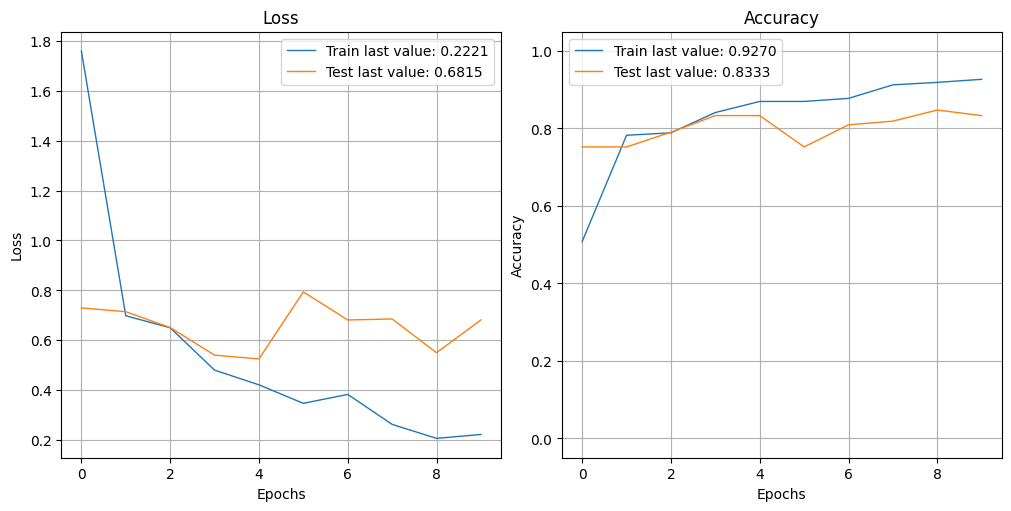

7/7 [==============================] - 20s 3s/step
[1, 0, 0, 1, 1, 3, 4, 4, 5, 1, 6, 2, 0, 1, 4, 3, 0, 4, 2, 0, 3, 6, 0, 6, 6, 3, 5, 4, 3, 5, 6, 4, 6, 5, 0, 0, 3, 6, 2, 2, 3, 6, 5, 5, 4, 6, 1, 0, 6, 2, 3, 3, 1, 1, 4, 2, 5, 0, 3, 4, 1, 0, 4, 0, 3, 6, 3, 1, 1, 1, 1, 3, 6, 1, 6, 2, 6, 1, 2, 3, 5, 6, 1, 3, 2, 0, 1, 0, 1, 4, 2, 0, 6, 5, 1, 5, 0, 3, 0, 6, 2, 1, 5, 4, 6, 5, 0, 2, 2, 5, 6, 5, 3, 1, 5, 4, 1, 1, 0, 4, 5, 4, 5, 0, 5, 5, 3, 3, 2, 3, 2, 3, 5, 6, 3, 1, 3, 4, 4, 0, 4, 6, 1, 0, 5, 0, 6, 4, 3, 3, 4, 4, 0, 2, 2, 5, 4, 1, 3, 2, 4, 6, 2, 0, 5, 6, 1, 3, 1, 5, 5, 2, 6, 0, 4, 2, 0, 2, 2, 5, 6, 4, 6, 2, 1, 3, 5, 0, 4, 6, 5, 2, 1, 5, 6, 1, 6, 3, 1, 1, 2, 6, 5, 4, 2, 2, 0, 0, 0, 2]

[3 0 0 1 1 3 4 4 5 1 6 3 4 1 4 3 0 4 2 0 3 6 3 6 6 4 5 5 3 5 6 4 6 5 0 4 3
 6 3 2 3 6 5 0 0 6 1 0 6 2 3 5 1 1 0 2 5 0 3 4 1 0 4 0 3 6 3 4 1 4 1 3 3 1
 6 2 6 1 2 3 5 6 5 3 2 0 1 0 1 4 2 0 6 5 1 5 0 3 5 6 2 1 5 4 6 5 0 2 5 5 6
 3 3 1 5 4 1 1 0 4 2 4 5 0 5 5 3 3 2 3 1 3 5 6 3 1 3 4 4 0 4 6 1 4 5 3 6 4
 3 3 4 0 0 2 2 5 

<Axes: >

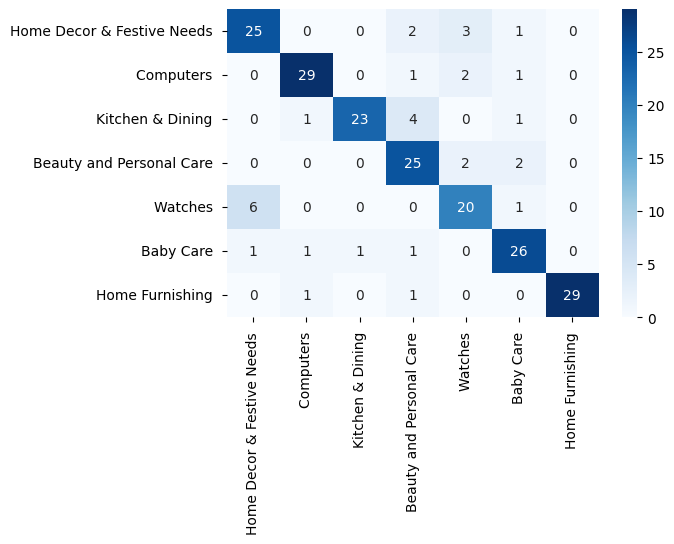

In [15]:
with tf.device('/gpu:0'): 
    model4 = create_model_fct_resnet50()

model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


model_reset_50 = KerasClassifier(model = create_model_fct_resnet50, verbose = 1)

param_dict = {
    "batch_size" : [16,32,64],
    "epochs" : [5,10,15],
             }

grid = GridSearchCV(
    param_grid = param_dict,
    estimator = model_reset_50,
    scoring = "accuracy",
    cv = 4,
    verbose = 1
)

batch_images, batch_labels = grid_flow.next()

with tf.device('/gpu:0'): 
    grid_model = grid.fit(batch_images,batch_labels, verbose=1)
    
print("Best: %f using %s" % (grid_model.best_score_, grid_model.best_params_))

with tf.device('/gpu:0'): 
    history4 = model4.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=grid_model.best_params_['batch_size'], epochs=grid_model.best_params_['epochs'], 
                          callbacks=callbacks_list, verbose=1)
    
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

y_test_num = test_flow.labels

y_test_pred = np.argmax(model4.predict(test_flow), axis=1)
print(y_test_num)
print()
print(y_test_pred)

conf_mat = metrics.confusion_matrix(y_test_num,y_test_pred)

print(conf_mat)
print()
print(metrics.classification_report(y_test_num, y_test_pred))

df_cm = pd.DataFrame(conf_mat, index = [label for label in set(raw["label"])],
              columns = [label for label in set(raw["label"])])
plt.figure(figsize = (6,4))

sns.heatmap(df_cm, annot=True, cmap="Blues")

